Get fields from Lumerical and save in file for later

In [1]:
import lumerical as lum
import numpy as  np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import imp
import time
import matplotlib.patches as patches

from scipy.constants import pi, c

lumapi = imp.load_source("lumapi", "C:/Program Files/Lumerical/2020a/api/python/lumapi.py")
MODE = lumapi.MODE("Template_Luis.lms")

Units

In [2]:
um = 1e-6
nm = 1e-9
THz = 1e12

Materials

In [3]:
material_substrate = "SiO2_analytic"
material_thinfilm = "LN_analytic_MgO_doped_xne"

Main waveguide parameters

slab = 0.360 um
width at the base = 2.243 um


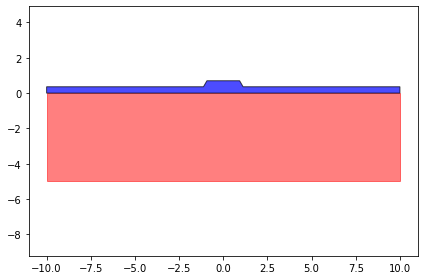

In [4]:
h_LN = 700*nm
h_etch = 340*nm
width_top = 1.85*um
h_slab = h_LN - h_etch

w_slab = 20*um
h_margin = 5*um
h_substrate = 5*um
meshsize = 50*nm
finemesh = 10*nm

theta = 60
wg_length = 10*um #Useless in MODE
width_top_base = width_top + 2*h_etch/np.tan(theta*pi/180)
w_sidewall = h_etch/np.tan(theta*pi/180)

print('slab = %.3f um' %(h_slab/um))
print('width at the base = %.3f um' %(width_top_base/um))

#Draw it
fig,ax = plt.subplots()
substrate = patches.Rectangle((-w_slab/2/um,-h_substrate/um), w_slab/um, h_substrate/um,
                             linewidth=1, edgecolor='r', facecolor='r', alpha=0.5)
v_ridge = np.array([[-width_top/2-w_sidewall,h_slab], [-width_top/2,h_LN],
                   [width_top/2,h_LN], [width_top/2+w_sidewall,h_slab],
                   [w_slab/2,h_slab], [w_slab/2,0], 
                   [-w_slab/2,0], [-w_slab/2, h_slab] ] )/um
ridge = patches.Polygon(v_ridge, linewidth=1, 
                       edgecolor='k', facecolor='blue', alpha=0.7)

ax.add_patch(substrate)
ax.add_patch(ridge)

plt.axis('equal')
plt.tight_layout()
plt.show()

Wavelength range

In [7]:
# f_start = 75*THz
f_start = 550*THz
f_stop = 1000*THz
f_step = 25*THz

freqs = np.arange(f_start, f_stop+1*THz, f_step)
# freqs = np.linspace(c/wl_stop, c/wl_start, num=Nwl)
wl = c/freqs

print('Wavelength list =', freqs/THz, ' THz')
print('Wavelength list =', wl/um, ' um')

Wavelength list = [ 550.  575.  600.  625.  650.  675.  700.  725.  750.  775.  800.  825.
  850.  875.  900.  925.  950.  975. 1000.]  THz
Wavelength list = [0.5450772  0.52137819 0.4996541  0.47966793 0.46121917 0.44413697
 0.42827494 0.41350684 0.39972328 0.38682898 0.37474057 0.3633848
 0.35269701 0.34261995 0.33310273 0.32409995 0.31557101 0.30747944
 0.29979246]  um


Draw waveguide and setup solver

In [8]:
lum.draw_wg(MODE, material_thinfilm, material_substrate,
              h_LN, h_substrate, h_etch, width_top, w_slab, theta, wg_length)
lum.add_fine_mesh(MODE, finemesh, h_LN, width_top_base, x_factor=1.2, y_factor=1.5)
lum.add_2D_mode_solver(MODE, meshsize, h_LN, h_substrate, 
                         w_slab, wg_length, h_margin)

In [ ]:
tic = time.time()
for kw in range(wl.size):
    MODE.switchtolayout()
    n, te = lum.solve_mode(MODE, wl[kw], nmodes=20)
        
    for km in range(n.size): #Look for first TE mode
        if te[km]>0.8:

            M = lum.mode()
            M.get_from_lumerical(MODE, km+1)
            Norm = M.N()
            neff = n[km]
            TE = te[km]

            data_filename = 'Data\LNoI_%inm_%inm_width_%inm_wl_%.1fnm_mode_%i' %(int(h_LN/nm), int(h_etch/nm), 
                                                                            int(width_top/nm), wl[kw]/nm, km)
            data_filename = data_filename.replace('.','p')
            np.savez(data_filename, M=M, neff=neff, tepf=TE, Norm=Norm,#Main results
                     h_LN=h_LN, h_etch=h_etch, width_top=width_top, wavelength=wl[kw], #Setup stuff
                     theta=theta, h_substrate=h_substrate, w_slab=w_slab, h_margin=h_margin, 
                     mesh_size=meshsize, finemesh=finemesh, 
                     material_substrate=material_substrate, material_thinfilm=material_thinfilm)
            
            break
    print('Wavelength %0.1f um completed' %(wl[kw]/um))
    
MODE.close()
toc = time.time()
print('Total time = %.1f  s' %(toc-tic))

In [ ]:
# N = 10
# neff = np.zeros([wl.size, N])
# TE = np.zeros([wl.size, N])
# Norm = np.zeros([wl.size, N])

# tic = time.time()
# for kw in range(wl.size):
#     MODE.switchtolayout()
#     n, te = lum.solve_mode(MODE, wl[kw], nmodes=20)
    
#     if n.size>=N:
#         neff[kw, :] = n[0:N]
#         TE[kw, :] = te[0:N]
#     else:
#         neff[kw, :] = np.concatenate([n, [0]*(N-n.size)])
#         TE[kw, :] = np.concatenate([te, [0]*(N-n.size)])
        
#     for km in range(min(n.size, N)):
#         M = lum.mode()
#         M.get_from_lumerical(MODE, km+1)
#         Norm[kw, km] = M.N()
        
#         data_filename = 'Data\LNoI_%inm_%inm_width_%inm_wl_%.1fum_mode_%i' %(int(h_LN/nm), int(h_etch/nm), 
#                                                                         int(width_top/nm), wl[kw]/nm, km)
#         data_filename = data_filename.replace('.','p')
#         np.savez(data_filename, M=M, neff=neff, tepf=TE, #Main results
#                  h_LN=h_LN, h_etch=h_etch, width_top=width_top, wavelength=wl[kw], #Setup stuff
#                  theta=theta, h_substrate=h_substrate, w_slab=w_slab, h_margin=h_margin, 
#                  mesh_size=meshsize, finemesh=finemesh, 
#                  material_substrate=material_substrate, material_thinfilm=material_thinfilm)
        
#     print('Wavelength %0.1f um completed' %(wl[kw]/um))